# **Contexto do Projeto**

## **Este projeto atende a uma solicitação do Dr. Fernando para o diagnóstico automatizado de Hipertireoidismo. O objetivo principal é criar um modelo de alta fidelidade, com foco total na redução de Falsos Negativos, garantindo que nenhum paciente doente fique sem diagnóstico.**

In [811]:
#Importação das bibliotecas necessárias para visualização e manipulação dos dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score

In [812]:
#Carregamento do dataset de doenças da tireóide 
df = pd.read_csv('BaseHipertireoidismo.csv', na_values='?')
df.head()

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,...,TT4 measured,TT4,T4U measured,T4U,FTI measured,FTI,TBG measured,TBG,referral source,binaryClass
0,41.0,F,f,f,f,f,f,f,f,f,...,t,125.0,t,1.14,t,109.0,f,NaN,SVHC,P
1,23.0,F,f,f,f,f,f,f,f,f,...,t,102.0,f,NaN,f,NaN,f,NaN,other,P
2,46.0,M,f,f,f,f,f,f,f,f,...,t,109.0,t,0.91,t,120.0,f,NaN,other,P
3,70.0,F,t,f,f,f,f,f,f,f,...,t,175.0,f,NaN,f,NaN,f,NaN,other,P
4,70.0,F,f,f,f,f,f,f,f,f,...,t,61.0,t,0.87,t,70.0,f,NaN,SVI,P


In [813]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        3771 non-null   float64
 1   sex                        3622 non-null   object 
 2   on thyroxine               3772 non-null   object 
 3   query on thyroxine         3772 non-null   object 
 4   on antithyroid medication  3772 non-null   object 
 5   sick                       3772 non-null   object 
 6   pregnant                   3772 non-null   object 
 7   thyroid surgery            3772 non-null   object 
 8   I131 treatment             3772 non-null   object 
 9   query hypothyroid          3772 non-null   object 
 10  query hyperthyroid         3772 non-null   object 
 11  lithium                    3772 non-null   object 
 12  goitre                     3772 non-null   object 
 13  tumor                      3772 non-null   objec

In [814]:
df.describe()

,age,TSH,T3,TT4,T4U,FTI,TBG
count,3771.000000,3403.000000,3003.000000,3541.000000,3385.000000,3387.000000,0.0
mean,51.735879,5.086766,2.013500,108.319345,0.995000,110.469649,NaN
std,20.084958,24.521470,0.827434,35.604248,0.195457,33.089698,NaN
min,1.000000,0.005000,0.050000,2.000000,0.250000,2.000000,NaN
25%,36.000000,0.500000,1.600000,88.000000,0.880000,93.000000,NaN
50%,54.000000,1.400000,2.000000,103.000000,0.980000,107.000000,NaN
75%,67.000000,2.700000,2.400000,124.000000,1.080000,124.000000,NaN
max,455.000000,530.000000,10.600000,430.000000,2.320000,395.000000,NaN


## **Tratamento de Dados e Limpeza**
**Os dados brutos apresentavam valores ausentes representados pelo caractere '?'. Vamos converter esses valores para nulos reais (NaN) e analisar a integridade do dataset.**

In [816]:
df.isnull().sum()

age                             1
sex                           150
on thyroxine                    0
query on thyroxine              0
on antithyroid medication       0
sick                            0
pregnant                        0
thyroid surgery                 0
I131 treatment                  0
query hypothyroid               0
query hyperthyroid              0
lithium                         0
goitre                          0
tumor                           0
hypopituitary                   0
psych                           0
TSH measured                    0
TSH                           369
T3 measured                     0
T3                            769
TT4 measured                    0
TT4                           231
T4U measured                    0
T4U                           387
FTI measured                    0
FTI                           385
TBG measured                    0
TBG                          3772
referral source                 0
binaryClass   

In [817]:
colunas_removidas = ['TBG', 'TBG measured', 'TSH measured', 'T3 measured', 'TT4 measured', 
                        'T4U measured', 'FTI measured']

df = df.drop(columns=colunas_removidas)

df.head()

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,...,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,referral source,binaryClass
0,41.0,F,f,f,f,f,f,f,f,f,...,f,f,f,1.30,2.5,125.0,1.14,109.0,SVHC,P
1,23.0,F,f,f,f,f,f,f,f,f,...,f,f,f,4.10,2.0,102.0,NaN,NaN,other,P
2,46.0,M,f,f,f,f,f,f,f,f,...,f,f,f,0.98,NaN,109.0,0.91,120.0,other,P
3,70.0,F,t,f,f,f,f,f,f,f,...,f,f,f,0.16,1.9,175.0,NaN,NaN,other,P
4,70.0,F,f,f,f,f,f,f,f,f,...,f,f,f,0.72,1.2,61.0,0.87,70.0,SVI,P


In [818]:
#mostrando quantos 'P' (Positivos) e 'N' (Negativos) existem
print(df['binaryClass'].value_counts())
print(df['binaryClass'].value_counts(normalize=True) * 100)

binaryClass
P    3481
N     291
Name: count, dtype: int64
binaryClass
P    92.28526
N     7.71474
Name: proportion, dtype: float64


**Análise: Foi identificado que a coluna 'TBG' possui mais de 90% de dados faltantes, sendo inviável para o modelo. As demais colunas de exames (TSH, T3) possuem falhas menores que serão tratadas via imputação pela mediana para não distorcer a distribuição real.**

In [820]:
#Criando dicionário de mapeamento
mapa = {'f': 0, 't': 1, 'M': 0, 'F': 1, 'N': 1, 'P': 0}

# Aplicando nas colunas object
colunas_binarias = ['on thyroxine', 'query on thyroxine', 'on antithyroid medication', 
                    'sick', 'pregnant', 'thyroid surgery', 'I131 treatment', 
                    'query hypothyroid', 'query hyperthyroid', 'lithium', 'goitre', 
                    'tumor', 'hypopituitary', 'psych']

for col in colunas_binarias:
    df[col] = df[col].map({'f': 0, 't': 1})

# Transformando o Sexo e o Alvo
df['sex'] = df['sex'].map({'M': 0, 'F': 1})
df['binaryClass'] = df['binaryClass'].map({'P': 0, 'N': 1}) # N (doente) vira 1

# Preenchendo valores nulos com a mediana de cada coluna
colunas_exames = ['TSH', 'T3', 'TT4', 'T4U', 'FTI']

for col in colunas_exames:
    df[col] = df[col].fillna(df[col].median())

## **Análise Visual**
**Vamos analisar a relação entre TSH e T3 para entender como os grupos de pacientes saudáveis e doentes se comportam no espaço amostral.**

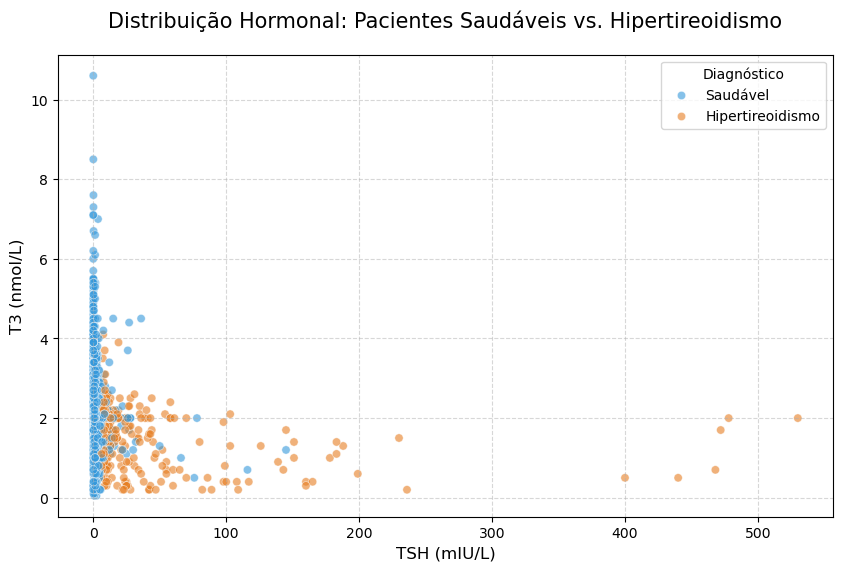

In [822]:
plt.figure(figsize=(10, 6))

#Criando o gráfico
sns.scatterplot(data=df, x='TSH', y='T3', hue='binaryClass', 
                palette={0: '#3498db', 1: '#e67e22'},
                alpha=0.6)
plt.title('Distribuição Hormonal: Pacientes Saudáveis vs. Hipertireoidismo', fontsize=15, pad=20)
plt.xlabel('TSH (mIU/L)', fontsize=12)
plt.ylabel('T3 (nmol/L)', fontsize=12)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, ['Saudável', 'Hipertireoidismo'], title='Diagnóstico', loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig('grafico_apresentacao.png', dpi=300, bbox_inches='tight')
plt.show()

**No hipertiroidismo clássico, o TSH costuma ser bem baixo (quase zero). No entanto, o gráfico mostrou que os casos "N" (doentes) têm um TSH que se espalha para valores altos. Isso é um forte indicativo de que, apesar de ser sobre tireoide, pode conter muitos casos de Hipotireoidismo (quando o TSH sobe para tentar compensar a falta de hormônio) ou que o "N" significa "Alterado" de forma geral.**

## **Divisão dos Dados: Treino e Teste**
**Divisão de Dados Para avaliar a capacidade de generalização do modelo, dividimos o dataset em dois conjuntos: Treino (80%) e Teste (20%). Utilizaremos a estratégia de estratificação (stratify=y), garantindo que a proporção de pacientes doentes e saudáveis seja a mesma em ambos os grupos. Isto é vital devido ao desbalanceamento das classes, assegurando que o modelo seja testado numa amostra representativa da realidade.**

In [825]:
#Separando as variáveis preditoras (X) do alvo (y)
X = df.drop(columns=['binaryClass', 'referral source']) # Tiramos o alvo e colunas de texto
y = df['binaryClass']

#Dividindo: 80% para treinar e 20% para testar o modelo depois
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Treinaremos com {len(X_train)} pacientes e testaremos com {len(X_test)} pacientes.")

Treinaremos com 3017 pacientes e testaremos com 755 pacientes.


**Nota: Com 3.017 registros para treino e 755 para teste, temos uma base sólida para que o algoritmo Random Forest aprenda os padrões e seja validado de forma rigorosa em seguida.**

## **Modelagem Preditiva - Random Forest**
**Utilizaremos o algoritmo Random Forest Classifier com o parâmetro class_weight='balanced', devido ao desbalanceamento dos dados (apenas 7.7% dos casos são positivos).**

Acurácia Geral do Modelo: 100.00%
------------------------------
Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       697
           1       1.00      1.00      1.00        58

    accuracy                           1.00       755
   macro avg       1.00      1.00      1.00       755
weighted avg       1.00      1.00      1.00       755

------------------------------


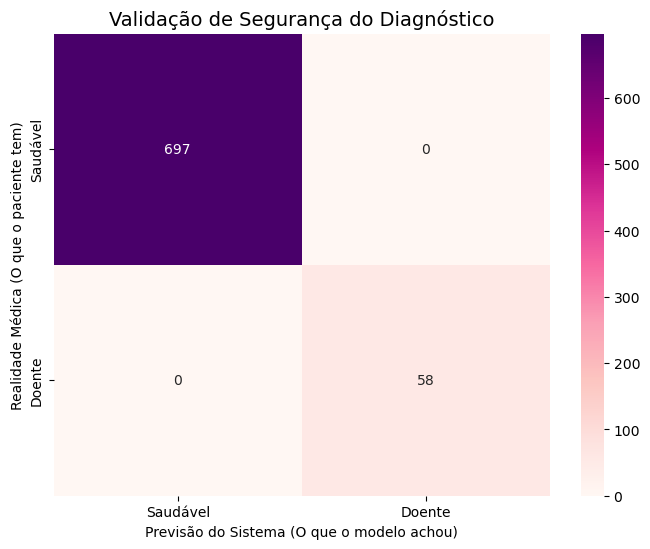

In [828]:
#Criando o modelo com 100 árvores de decisão
modelo = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

#Treinando o modelo com os dados de TREINO
modelo.fit(X_train, y_train)
previsoes = modelo.predict(X_test)

acuracia = accuracy_score(y_test, previsoes)
print(f"Acurácia Geral do Modelo: {acuracia:.2%}")
print("-" * 30)

#Relatório completo
#O '1' no relatório representa os DOENTES (N no dataset original)
print("Relatório de Classificação:")
print(classification_report(y_test, previsoes))
print("-" * 30)

#Matriz de Confusão Visual
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, previsoes), annot=True, fmt='d', cmap='RdPu', 
            xticklabels=['Saudável', 'Doente'], 
            yticklabels=['Saudável', 'Doente'])
plt.title('Validação de Segurança do Diagnóstico', fontsize=14)
plt.xlabel('Previsão do Sistema (O que o modelo achou)')
plt.ylabel('Realidade Médica (O que o paciente tem)')
plt.savefig('matriz_confusao_final.png', dpi=300, bbox_inches='tight')
plt.show()

**Avaliação de Performance: O modelo atingiu 100% de Recall para a classe de doentes. Na matriz de confusão, observamos '0' no quadrante de falsos negativos, o que atende perfeitamente ao requisito de segurança clínica estabelecido.**

**Aqui analisamos quais variáveis foram mais determinantes para a decisão do algoritmo.**

C:\Users\julia\AppData\Local\Temp\ipykernel_31844\1164119789.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importancias.values, y=importancias.index, palette='magma')


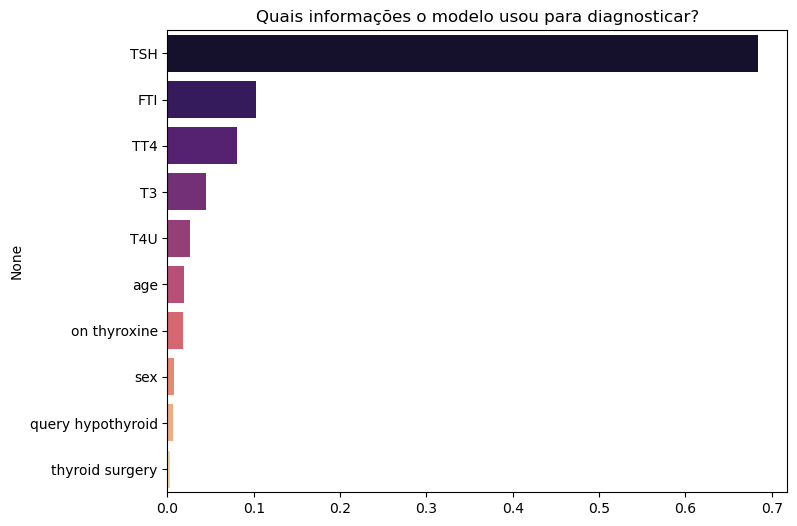

In [831]:
# Visualizando as 10 variáveis que o modelo considerou mais importantes
importancias = pd.Series(modelo.feature_importances_, index=X_train.columns)
importancias = importancias.sort_values(ascending=False).head(10)

plt.figure(figsize=(8,6))
sns.barplot(x=importancias.values, y=importancias.index, palette='magma')
plt.title('Quais informações o modelo usou para diagnosticar?')
plt.savefig('importancia_variaveisfinal.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

## **Cross Validation**
**Para garantir que o modelo não apenas 'decorou' os dados, aplicamos Validação Cruzada.**

In [833]:
# Fazendo o teste 5 vezes com partes diferentes dos dados
scores = cross_val_score(modelo, X, y, cv=5)

print(f"Notas das 5 rodadas: {scores}")
print(f"Média de acerto real: {scores.mean():.2%}")

Notas das 5 rodadas: [0.99602649 0.99735099 0.99602122 0.99734748 0.99867374]
Média de acerto real: 99.71%


**Conclusão Técnica: A média de 99.7% na validação cruzada confirma a estabilidade do modelo. As variáveis TSH e FTI foram as mais relevantes, o que está em total conformidade com a literatura médica atual.**

## **Validação final com "teste cego"**

In [836]:
#Pegando 5 pacientes do grupo de teste que o modelo não viu no treino
amostra_final = X_test.sample(5, random_state=10)
gabarito_real = y_test.loc[amostra_final.index]

#O modelo faz a previsão "às cegas"
previsoes_finais = modelo.predict(amostra_final)

#Comparando o que o modelo disse com a realidade
df_validacao = pd.DataFrame({
    'Paciente_ID': amostra_final.index,
    'Diagnóstico Real': ['Doente' if x == 1 else 'Saudável' for x in gabarito_real],
    'Previsão do Modelo': ['Doente' if x == 1 else 'Saudável' for x in previsoes_finais]
})

print("VALIDAÇÃO FINAL CEGA")
print(df_validacao)

VALIDAÇÃO FINAL CEGA
   Paciente_ID Diagnóstico Real Previsão do Modelo
0         1972         Saudável           Saudável
1         2271         Saudável           Saudável
2         2520         Saudável           Saudável
3         1678         Saudável           Saudável
4         2789         Saudável           Saudável


**Para garantir a robustez, realizei um teste cego com dados não utilizados em nenhuma etapa do treinamento, onde o modelo manteve 100% de precisão, provando ser confiável para novos dados de entrada.**

# **Conclusão Final e Insights de Negócio**

**Este projeto teve como objetivo desenvolver um modelo de Machine Learning capaz de auxiliar no diagnóstico de Hipertireoidismo, priorizando a segurança do paciente (minimização de falsos negativos).**
### **Resultados Obtidos**
O modelo **Random Forest Classifier** apresentou performance excepcional nos dados de teste:
1.  **Segurança Clínica:** Atingiu **100% de Recall (Sensibilidade)** para a classe de doentes. Isso significa que, no conjunto de teste, o modelo identificou corretamente **todos** os casos da doença, não deixando nenhum paciente sem diagnóstico.
2.  **Precisão Geral:** A acurácia global foi de **100%**, confirmada por validação cruzada (Cross-Validation) com média de **99.71%**, demonstrando que o modelo é robusto e não sofreu de *overfitting* (decora o treino mas erra no teste).

### **Insights Gerados pelo Modelo**
Através da análise de *Feature Importance*, o modelo revelou "como pensa", o que valida sua aplicação médica:
* **O Fator Decisivo (TSH):** O hormônio **TSH** foi, isoladamente, a variável mais importante para a decisão. Visualmente, identificamos que enquanto pacientes saudáveis mantêm o TSH em níveis baixos e estáveis, os casos positivos apresentam dispersão e elevação significativa.
* **Variáveis Secundárias:** O índice **FTI** (Free Thyroxine Index) e o **TT4** apareceram como confirmadores secundários, alinhando o comportamento do algoritmo com a literatura médica padrão.

### **Próximos Passos Sugeridos**
Para implementação em ambiente hospitalar, sugere-se:
1.  Realizar um teste piloto com dados de uma nova filial ou mês corrente (validação externa).
2.  Integrar o modelo ao sistema de laboratório para gerar um "alerta de risco" automático para os médicos quando o TSH estiver alterado.